<a href="https://colab.research.google.com/github/ApplesDaddy/CMPT353Project/blob/rf_regress/regression_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!conda --version
!which python
!python --version
!echo $PYTHONPATH

In [ ]:
%env PYTHONPATH=
!echo $PYTHONPATH

In [ ]:
# most recent install link from https://docs.anaconda.com/free/miniconda/miniconda-other-installer-links/
!wget https://repo.anaconda.com/miniconda/Miniconda3-py310_24.1.2-0-Linux-x86_64.sh
!chmod +x Miniconda3-py310_24.1.2-0-Linux-x86_64.sh
!bash ./Miniconda3-py310_24.1.2-0-Linux-x86_64.sh -b -f -p /usr/local/

In [ ]:
!which conda
!conda --version
!conda install --channel defaults conda python=3.10 --yes
!conda update --channel defaults --all --yes

In [ ]:
import sys
sys.path

In [ ]:
!ls /usr/local/lib/python3.10/dist-packages

In [ ]:
sys.path.append("/usr/local/lib/python3.10/site-packages")
!conda config --add channels conda-forge

In [ ]:
!conda create --name musemotion_meta -c conda-forge numpy pandas matplotlib scikit-learn wandb pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

In [ ]:
# !conda init
# !conda activate musemotion_meta
# credit https://stackoverflow.com/a/62668276
%%shell
eval "$(conda shell.bash hook)"
conda activate musemotion_meta

In [ ]:
pip install wandb -qU

# Load data
_Note_: tempo = bpm

In [3]:
!mkdir datasets
import urllib.request
urllib.request.urlretrieve("https://github.com/zhandrew4/music-mood-classification/raw/main/muse_v3.csv", "datasets/muse_v3.csv")
urllib.request.urlretrieve("https://github.com/zhandrew4/music-mood-classification/raw/main/full_data.csv", "datasets/full_data.csv")

mkdir: cannot create directory ‘datasets’: File exists


('datasets/full_data.csv', <http.client.HTTPMessage at 0x7f27eb68d550>)

In [1]:
import pandas as pd
sample = pd.read_csv("datasets/full_data.csv", nrows=3)
sample.columns

Index(['Unnamed: 0', 'track', 'artist', 'seeds', 'spotify_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [2]:
import numpy as np

KEEP_COLS_MASTER = ["track", "album", "artist", "release_date", "length",
             "tempo", "key", "time_signature",
             "mood"]

KEEP_COLS_MODEL = ["tempo", "key", "loudness", "time_signature", "duration_ms"]

# songs_df = pd.read_csv("data_moods.csv", usecols=KEEP_COLS_MASTER)
# make names the indices
# make sure same data type as what model layers will be
songs_df = pd.read_csv("datasets/full_data.csv", usecols=["track", "artist"]+KEEP_COLS_MODEL,
                       parse_dates=True, infer_datetime_format=True,
                       dtype={ft: np.float32 for ft in KEEP_COLS_MODEL})
# print(songs_df[songs_df["track"] == "Michael Hedges"])
# print(songs_df[songs_df["artist"] == "Michael Hedges"])
songs_df.set_index(["track", "artist"], inplace=True)
print(songs_df)

/tmp/ipykernel_44370/3491296439.py:12: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  songs_df = pd.read_csv("datasets/full_data.csv", usecols=["track", "artist"]+KEEP_COLS_MODEL,


                                                    key  loudness       tempo  \
track                            artist                                         
'Till I Collapse                 Eminem             1.0    -3.237  171.447006   
St. Anger                        Metallica          2.0    -2.642  185.251999   
Speedin'                         Rick Ross          1.0    -4.226  100.058998   
Bamboo Banga                     M.I.A.             9.0    -4.554  125.984001   
Die MF Die                       Dope               5.0    -3.524  126.019997   
...                                                 ...       ...         ...   
Secret                           Quietdrive         0.0    -5.126  167.996002   
The Last of the Rest Was the End Medications        2.0    -5.774  144.843994   
Lovechild                        Daniel Lanois     10.0   -20.091   79.475998   
Last Inhale                      Tapage             2.0    -8.977  160.011002   
Unfold                      

Convert dates to numbers, specfically seconds.

_Note_: This goddamn dataset only gives the year for some songs.

In [3]:
# print(songs_df[songs_df["release_date"]=="1993"])
# # credit https://stackoverflow.com/a/54312941
# songs_df["release_date"] = pd.to_datetime(songs_df["release_date"], format="mixed").astype(int)/ 10**9
# songs_df["release_date"]

Load the V, A, D dimension values from the original MuSe dataset and add them to the rest of the data.
^ Join V, A, D columns by key columns title and author.

In [4]:
import pandas as pd
import numpy as np

LABELS_COLS = ['valence_tags', 'arousal_tags', 'dominance_tags']

orig_dataset = pd.read_csv("datasets/muse_v3.csv")
print(orig_dataset.columns)
orig_dataset = pd.read_csv("datasets/muse_v3.csv",
                           usecols=["track", "artist"]+LABELS_COLS,
                           dtype={tag: np.float32 for tag in LABELS_COLS})
orig_dataset.set_index(["track", "artist"], inplace=True)
orig_dataset

Index(['lastfm_url', 'track', 'artist', 'seeds', 'number_of_emotion_tags',
       'valence_tags', 'arousal_tags', 'dominance_tags', 'mbid', 'spotify_id',
       'genre'],
      dtype='object')


,,valence_tags,arousal_tags,dominance_tags
track,artist,,,
'Till I Collapse,Eminem,4.550000,5.273125,5.690625
St. Anger,Metallica,3.710000,5.833000,5.427250
Speedin',Rick Ross,3.080000,5.870000,5.490000
Bamboo Banga,M.I.A.,6.555071,5.537214,5.691357
Die MF Die,Dope,3.771177,5.348235,5.441765
...,...,...,...,...
Battle,Gaby Hoffmann & Jay Duplass,5.370000,3.450000,5.330000
Hands Tied to the Roots of a Hemorrhage,Omar Rodriguez-Lopez,5.797887,4.132254,5.570563
Crookfield Zoo,Ace White,5.370000,3.450000,5.330000


In [5]:
VAL_COLS = ["valence_tags","arousal_tags","dominance_tags"]
songs_df = songs_df.join(orig_dataset, how="inner")

In [6]:
songs_df

,,key,loudness,tempo,duration_ms,time_signature,valence_tags,arousal_tags,dominance_tags
track,artist,,,,,,,,
'Till I Collapse,Eminem,1.0,-3.237,171.447006,297787.0,4.0,4.550000,5.273125,5.690625
St. Anger,Metallica,2.0,-2.642,185.251999,441133.0,4.0,3.710000,5.833000,5.427250
Speedin',Rick Ross,1.0,-4.226,100.058998,204960.0,4.0,3.080000,5.870000,5.490000
Bamboo Banga,M.I.A.,9.0,-4.554,125.984001,298360.0,4.0,6.555071,5.537214,5.691357
Die MF Die,Dope,5.0,-3.524,126.019997,186067.0,4.0,3.771177,5.348235,5.441765
...,...,...,...,...,...,...,...,...,...
Secret,Quietdrive,0.0,-5.126,167.996002,258373.0,4.0,5.370000,3.450000,5.330000
The Last of the Rest Was the End,Medications,2.0,-5.774,144.843994,324000.0,3.0,5.370000,3.450000,5.330000
Lovechild,Daniel Lanois,10.0,-20.091,79.475998,516280.0,4.0,6.685000,4.405000,5.625000


In [7]:
# Check for duplicates
songs_df.index.is_unique

True

### Check for outliers

In [8]:
import pandas as pd
import numpy as np
from scipy import stats

In [9]:
# function to detect outliers with z-score
def detect_outliers_zscore(data, threshold = 3):
    z_scores = np.abs(stats.zscore(data))
    return data[(z_scores > threshold).any(axis=1)]

In [10]:
# function to detect outliers with IQR
def detect_outliers_iqr(data, threshold = 1.5):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    return data[((data < (q1 - threshold*iqr)) | (data > (q3 + threshold*iqr))).any(axis = 1)]

In [11]:
outliers_zscore = detect_outliers_zscore(songs_df[VAL_COLS])

In [12]:
outliers_iqr = detect_outliers_iqr(songs_df[VAL_COLS])

In [13]:
print(outliers_zscore)
print(outliers_iqr)

                                                                       valence_tags  \
track                                              artist                             
Conflict (live)                                    Disturbed               0.401739   
Apollo I : The Writing Writer - Explicit Album ... Coheed and Cambria      0.940154   
Let's Have a War                                   Fear                    0.976667   
When The President Talks To Go                     Bright Eyes             1.566486   
Untitled                                           Kevin Max               1.525000   
...                                                                             ...   
Dying Brokenhearted                                Empyrium                1.465882   
Higher State of Consciousness (Tweekin Acid Funk)  Wink                    2.620000   
Outtathaway                                        Vines, The              1.247273   
Early Morning Rain                         

In [14]:
print(f"outliers by z-score: {len(outliers_zscore.index) / len(songs_df.index)} of dataset")
print(f"outliers by interquartile range: {len(outliers_iqr.index) / len(songs_df.index)} of dataset")

outliers by z-score: 0.006506888214581271 of dataset
outliers by interquartile range: 0.018271212293312997 of dataset


Visualize the distribution within each input feature column, i.e. distribution of key signatures across songs, of time signatures across songs, of ...

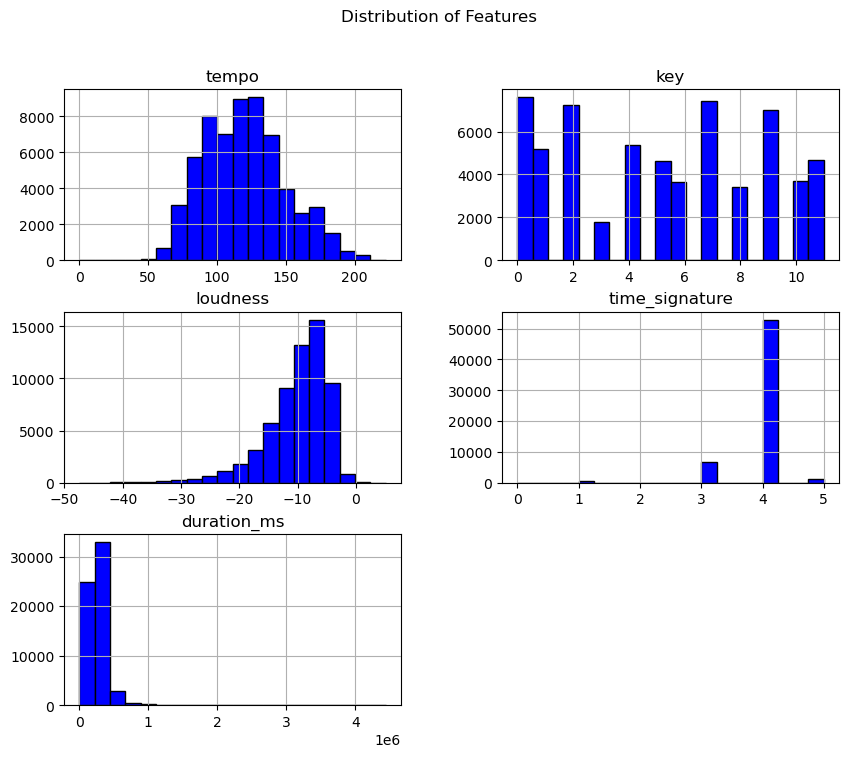

In [15]:
import matplotlib.pyplot as plt

# histogram for each column
songs_df[KEEP_COLS_MODEL].hist(figsize=(10,8), bins = 20, color = 'blue', edgecolor = 'black')
plt.suptitle('Distribution of Features')
plt.show()

Model will take data as (`X_train`,`y_train`)
- `X_train` is a 2D NumPy array of shape `n_samples` x `n_features`, i.e. one song per row, one metadata feature per column
- `y_train` is just convert the "mood" column into a 1D NumPy array

In [16]:
# How much should we take for training, testing?
songs_df.index.size

0.8 * songs_df.index.size

49301.600000000006

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

DROP_COLS = VAL_COLS#+["artist"]
# use a constant random state for reproducibility
# X = songs_df.drop(columns=DROP_COLS)
# y = songs_df[VAL_COLS]
X_train, X_test, y_train, y_test = train_test_split(songs_df.drop(columns=DROP_COLS), songs_df[VAL_COLS],
                                                    test_size=0.2, random_state=42)

## Set up Weights & Biases

In [18]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: t0m_x. Use `wandb login --relogin` to force relogin


True

### Log the Input Data
Keep track of exactly what train-test split was used on this run using [WandB artifacts](https://docs.wandb.ai/guides/track/log/log-tables).

In [19]:
with wandb.init(project="Music Mood Prediction", job_type="data_split") as run:
    # log the data subsets
    for subset, data in zip(["X_train", "X_test", "y_train", "y_test"], [X_train, X_test, y_train, y_test]):
        artifact = wandb.Artifact(subset, type="dataset")
        wandb_table = wandb.Table(dataframe=data)
        artifact.add(wandb_table, subset)
        run.log_artifact(artifact)

# Model

## Multi-Layer Perceptron
[PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

[Building a Regression Model in PyTorch](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/)

[ChatGPT PyTorch Regression Model](https://chat.openai.com/share/8e1237ca-a45f-4abc-8740-25ca00d72bbf)

In [20]:
# from sklearn.neural_network import MLPRegressor

# mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=())

# # terrible score lol
# mlp_regression = mlp.fit(X_train, y_test)
# print(mlp_regression.score(X_test, y_test))

In [21]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [23]:
# print(type(X_train), X_train)

In [24]:
# print(X_test)

In [25]:
# print(y_test)

In [26]:
# print(y_train)

In [27]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (12326, 5)
Shape of y_test: (12326, 3)


In [28]:
# credit: https://stackoverflow.com/questions/71198218/the-simple-mlp-nn-for-regression-in-pytorch-very-slow-learning-rev2
# credit: https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216/2

# BatchNorm1d is used for 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout1_p=0.5, dropout2_p=0.5):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            # batch norm after each fully connected layer
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU(),
            nn.Dropout(dropout1_p),
            # nn.Linear(hidden_size1, hidden_size2),
            # nn.BatchNorm1d(hidden_size2),
            # nn.ReLU(),
            # nn.Dropout(dropout2_p),
            # nn.Linear(hidden_size2, output_size)
            nn.Linear(hidden_size1, output_size)
        )

    def forward(self, x):
        return self.layers(x)


# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_p=0.5):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)
#         self.dropout = nn.Dropout(dropout_p)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

In [29]:
from torch.utils.data import DataLoader, TensorDataset
# # convert dataframe to PyTorch Tensor
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 32

Clean up data retrieving and storage with a [custom PyTorch DataSet class](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [30]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

class SongMetaDataSet(torch.utils.data.Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.DataFrame, standardize=True):
        """
        X is a tensor or DataFrame of the input features (i.e. song metadata), one row per song.
        y is a tensor or DataFrame of the target values (i.e. valence, arousal, dominance), one row per song.
        __All must have the (song name, artist) as the multi-index.__
        """
        # sort all by index to ensure they match
        for inp in (X, y):
            if not isinstance(inp, pd.DataFrame):
                raise ValueError(f"{inp} must be a pandas DataFrame")
            if len(inp.index.names) < 2:
                raise ValueError(f"{inp} must have song names and artists in its index")
        if len(X.index) != len(y.index):
            raise ValueError("X and y must be the same length")

        if standardize:
            # standardize the input features
            self.X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
        else:
            self.X = X
        # self.X.sort_index(inplace=True)
        self.y = y
        # self.y.sort_index(inplace=True)

    def __len__(self):
        return len(self.X.index)

    def __getitem__(self, idx) -> tuple[tuple[str,str], torch.Tensor, torch.Tensor]:
        """
        The returned tuple contains:
            1. a tuple of the song's (name, artist)
            2. the input features vector for this song
            3. the target vector (V, A, D values) for this song
        """
        # keep intermediate for y to extract index = (name, artist)
        labels_df = self.y.iloc[[idx]]
        if len(labels_df.index) > 1:
            print("Warning: indexing DataSet gave more than one song, only keeping the first")
        # > PyTorch's DataLoader will automatically stack the arrays along the first dimension (axis 0) when creating a batch
        #       ^ credit: Google Colab AI
        # but don't care, don't need to batch during testing
        IDs_pair = labels_df.index.values[0]
        return IDs_pair, torch.from_numpy(self.X.values[idx]), torch.from_numpy(labels_df.values)

def make_song_dataset(songs_df: pd.DataFrame, input_cols: list[str], label_cols: list[str]) -> SongMetaDataSet:
    """
    songs_df is a DataFrame of song metadata, with the song names as the index.
    input_cols is a list of columns to use as the input features (i.e. tempo, key, loudness).
    id_cols is a list of columns to include in the identifying information for each song.
    label_cols is a list of columns to use as the target values (i.e. valence, arousal, dominance).
    """
    X = songs_df[input_cols]
    y = songs_df[label_cols]
    return SongMetaDataSet(X, y)

In [31]:
# songs_df.loc[X_test.index]

In [32]:
# train_idx = X_train.index.values
# test_idx = X_test.index.values
# print(songs_df.loc[train_idx, KEEP_COLS_MODEL], songs_df.loc[train_idx, VAL_COLS], songs_df.loc[train_idx, "artist"])

train_dataset = make_song_dataset(songs_df.loc[X_train.index], KEEP_COLS_MODEL, VAL_COLS)
test_dataset = make_song_dataset(songs_df.loc[X_test.index], KEEP_COLS_MODEL, VAL_COLS)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

Visualize the distributions after standardization

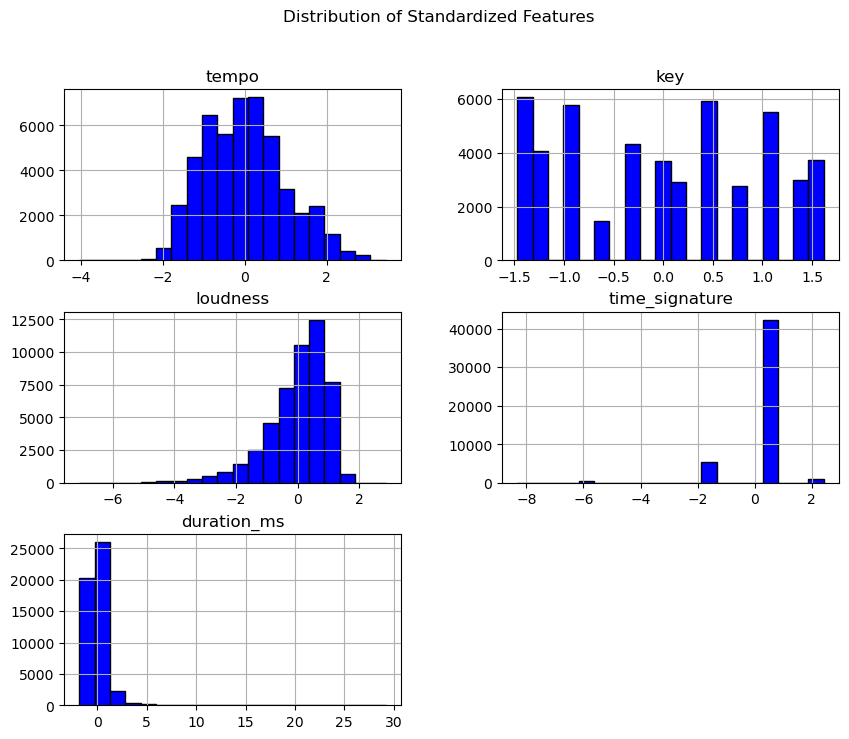

In [33]:
train_dataset.X[KEEP_COLS_MODEL].hist(figsize=(10,8), bins = 20, color = 'blue', edgecolor = 'black')
plt.suptitle('Distribution of Standardized Features')
plt.show()

Check what the batches look like

In [34]:
train_dataset[0]

(('Newst Flurries', 'Brad Barr'),
 tensor([-1.3563,  1.6185, -0.6389,  0.2700,  0.0095]),
 tensor([[7.2125, 4.1975, 6.4750]]))

In [35]:
for loader in [test_loader,train_loader]:
    print("Loader ", loader)
    for name_artist_pair, inputs, targets in loader:
        name, artist = name_artist_pair[0][0], name_artist_pair[1][0]
        print(f"{name} by {artist}")
        # print(f"{name_artist_pair[0]} by {name_artist_pair[1]}:")
        print("\tInputs:", inputs.shape, inputs.dtype)
        print("\t", inputs)
        print("\tLabel:", targets.shape, inputs.dtype)
        print("\t", targets)
        break

Loader  <torch.utils.data.dataloader.DataLoader object at 0x7f0f4b8f8740>
Les OS by The Unicorns
	Inputs: torch.Size([1, 5]) torch.float32
	 tensor([[ 1.7361,  0.5013,  0.4403,  0.2623, -0.3816]])
	Label: torch.Size([1, 1, 3]) torch.float32
	 tensor([[[5.6347, 4.3712, 4.9132]]])
Loader  <torch.utils.data.dataloader.DataLoader object at 0x7f0f4f552a80>
Phosphene by Deathspell Omega
	Inputs: torch.Size([32, 5]) torch.float32
	 tensor([[-0.4444,  0.4962,  1.2679,  0.2700,  1.0691],
        [ 2.0047, -0.9068,  0.3225, -1.8752, -0.1550],
        [-0.8413, -1.1874,  1.1162,  0.2700, -0.1603],
        [-0.3408,  1.3379, -0.3606,  0.2700,  0.5899],
        [ 0.4447,  1.6185, -2.2283,  0.2700,  0.0668],
        [-0.2305,  0.7767, -0.1288,  0.2700, -0.1787],
        [-0.0322, -0.0650,  1.0236,  0.2700, -0.3644],
        [-0.6119, -0.9068,  0.3377,  0.2700,  0.8608],
        [ 0.1903,  0.4962, -0.3549,  0.2700,  0.0312],
        [-0.1728, -0.3456,  0.8635,  0.2700, -0.4290],
        [ 0.0407,  0.

`<<<<<<< HEAD`

In [36]:
# input_size = X_train.shape[1]
# hidden_size1 = 6
# hidden_size2 = 4
# output_size = y_train.shape[1]  # Assuming y_train has multiple output columns
# model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size).to(device)


# credit for hyperparameter values during this iteration:
# http://hdip-data-analytics.com/help/machine_learning/keras/rot#:~:text=Number%20of%20Layers%3A%20Start%20with%20two%20hidden%20layers,next%20layer%20size%20as%20half%20of%20the%20previous

sweep_config = {
    "name": "MLP Sweep",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "test loss"},
    "parameters": {
        "input_size": {"value": X_train.shape[1]},
        "hidden_size1": {"min": 4, "max": 4},
        "hidden_size2": {"min": 2, "max": 4},
        "hidden_size3": {"min": 2, "max":2},
        "output_size": {"value": y_train.shape[1]},
        "epochs": {"min": 3, "max": 6},
        "dropout1_p": {"min": 0.0, "max": 0.2},
        "dropout2_p": {"min": 0.1, "max": 0.5},
        "learning_rate": {"min": 0.001, "max": 0.1}
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 3
    }
}
X_train.shape[1]

5

`=======`

In [36]:
# input_size = X_train.shape[1]
# hidden_size1 = 6
# hidden_size2 = 4
# output_size = y_train.shape[1]  # Assuming y_train has multiple output columns
# model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size).to(device)


# credit for hyperparameter values during this iteration:
# http://hdip-data-analytics.com/help/machine_learning/keras/rot#:~:text=Number%20of%20Layers%3A%20Start%20with%20two%20hidden%20layers,next%20layer%20size%20as%20half%20of%20the%20previous

sweep_config = {
    "name": "MLP Sweep",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "test loss"},
    "parameters": {
        "input_size": {"value": X_train.shape[1]},
        "hidden_size1": {"min": 4, "max": 4},
        "hidden_size2": {"min": 2, "max": 4},
        "hidden_size3": {"min": 2, "max":2},
        "output_size": {"value": y_train.shape[1]},
        "epochs": {"min": 5, "max": 20},
        "dropout_p": {"min": 0.3, "max": 0.5},
        "learning_rate": {"min": 0.001, "max": 0.1}
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 3
    }
}
X_train.shape[1]

5

`>>>>>>> 7d428e7cc83a66b816380ac110445457bb4a5311`

In [37]:
sweep_id = wandb.sweep(sweep_config, project="Music Mood Prediction")

Create sweep with ID: optbqa8r
Sweep URL: https://wandb.ai/t0m_x/Music%20Mood%20Prediction/sweeps/optbqa8r


In [38]:
import torch.optim as optim
import torch.utils
import torch.utils.data
import os

TEST_TABLE_COLS = [
    "name",
    "artist",
    "tempo",
    "key signature",
    "loudness",
    "time signature",
    "duration (ms)",
    "predicted valence",
    "predicted arousal",
    "predicted dominance"
]

def train_epoch(train_loader, model, optimizer, criterion):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for _, inputs, targets in train_loader:
        print(f"training on {_}")

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def test(test_loader: torch.utils.data.DataLoader, model: torch.nn.Module, criterion: torch.nn.Module, wandb_run=None):
    """
    record test examples and predictions in W&B table
    optionally save the table as an artifact
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    test_table = wandb.Table(columns=TEST_TABLE_COLS)

    with torch.no_grad():
        for name_artist_pairs, inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            # Display and log some test examples <- input and output
            name, artist = name_artist_pairs[0][0], name_artist_pairs[1][0]
            print(f"{name} by {artist}")
            print(f'input: {inputs.cpu().numpy()}')
            print(f'output: {outputs.cpu().numpy()}')
            all_cells_vals = [name, artist] + inputs.flatten().tolist() + outputs.flatten().tolist()
            test_table.add_data(*all_cells_vals)

        test_loss /= len(test_loader.dataset)
        wandb.log({"prediction examples": test_table}, commit=False)

        # if wandb_run:
        #     preds_arfct = wandb.Artifact("predictions", type="dataset", description="Predictions on test set, with song name and artist, input features and predicted V, A, D values.")
        #     preds_arfct.add(test_table, "predictions")
        #     wandb_run.log_artifact(preds_arfct)

        return test_loss

def pipeline(config=None, train_loader: torch.utils.data.DataLoader=train_loader, test_loader: torch.utils.data.DataLoader = test_loader, model_save_dir="models") -> tuple[nn.Module, float]:
    """Build and train a model, return the model and the test loss"""
    # Initialize a new wandb run for this hyperparameter configuration
    # config will be set by Sweep Controller
    with wandb.init(project="Music Mood Prediction", name="MLP Regressor", config=config) as run:
        config = wandb.config

        # for saving for future reference
        # model_arfct = wandb.Artifact("model", type="model")

        # build the model
        model = NeuralNetwork(config["input_size"], config["hidden_size1"], config["hidden_size2"], config["output_size"], config["dropout1_p"], config["dropout2_p"]).to(device)

        # define the loss function and the optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

        wandb.watch(model, criterion, log="all", log_freq=10)

        num_epochs = config["epochs"]
        avg_loss = 0.0
        print(f"Training for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            avg_loss = train_epoch(train_loader, model, optimizer, criterion)
            print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")

            test_loss = test(test_loader, model, criterion, run)
            print(f'test loss: {test_loss:.4f}')

            wandb.log({"train loss": avg_loss, "test loss": test_loss, "epoch": epoch})

        # save the model
        # save_path = os.path.join(model_save_dir, f"MLP_{run.id}.pth")
        # torch.save(model.state_dict(), save_path)
        # model_arfct.add_file(save_path)

        return model, test_loss

wandb.agent(sweep_id, function=pipeline, count=9)

wandb: Agent Starting Run: jcgsqc81 with config:
wandb: 	dropout1_p: 0.11171701340270752
wandb: 	dropout2_p: 0.1814439601650535
wandb: 	epochs: 12
wandb: 	hidden_size1: 3
wandb: 	hidden_size2: 8
wandb: 	input_size: 5
wandb: 	learning_rate: 0.016450344868679884
wandb: 	output_size: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training for 12 epochs...
training on [['Chocolate Girl', 'Baader-Meinhof Blues', 'The Ritual', 'All In White', 'The Only', 'Transparent Stones', 'Hope Springs Temperamental', 'Pedestal', "El Pito (I'll Never Go Back To Georgia)", 'Strange Waters', "St. Peter's Day Festival", 'Klucznik', 'The Landlord Is Dead', 'Pank Is Ded', 'Wave', 'Inside of You, In Spite of You', 'Anarchy Burger (Hold the Government)', 'Emancipation', 'Australian Dawn - The Quiet Earth Cries Inside', 'Salute to the Sun', 'Le Desir', 'Free or Dead', 'Amanda', 'Manhattan 3:25 Am', 'Homesick', 'The Key of Netherworld, Pt. 2: Through The Darkness, For a New Hope', 'Blue Melody', 'Things not to be Done on the Sabbath', 'we are the underground', 'About the Moon', 'How Shall Our Judgement Be Carried Out Upon The Wicked?', 'Ĉiuj Ni Amegas Usonon'], ['Animal Collective', 'Legião Urbana', 'Saul Williams', 'The Vaccines', 'Sasha Sloan', 'Bergman', 'Jonathan Burks', 'Fergie', 'Joe Cuba', 'Bruce Cockburn', 'Ra Ra Riot', 'Lao Ch

/usr/shared/CMPT/scratch/wxa38/miniforge3/envs/musemotion_meta/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 3])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training on [['Hooray', 'Tricks of the Trade', 'Ruusu, tulppaani ja peyote', 'Forest of Arches', 'The Men Are Called Horsemen There', 'Feels Good', 'Trampoline', 'Hora Di Petrosnitza', 'Hokkaido', 'Blackbird', "Espacio (feat. Lil' Kim & G-Dep)", 'Born On The Cusp', "What We Fall For When We're Already Down", 'I Said', 'Like a Bull', 'Look Where We Are Now', 'Elle Et Moi', 'Stargazer', 'Hurricane Glass', 'Desperate', 'Westerly Prayer', 'Mole', 'Shut You In The Dark', 'Song Against Sex', 'Mornings Eleven', 'Chemistry of a Car Crash', 'Cracked Plaster Cast', 'Looking at the Sun', 'Xanax', 'Lamento Eroico', 'Anything', 'Forced Laugh'], ['Minus the Bear', 'Mew', 'Mana Mana', 'Rudi Arapahoe', 'Sunset Rubdown', 'Next', 'Rachael Sage', 'Fanfare Ciocărlia', 'Amon Tobin', 'The Beatles', 'Black Rob', 'The American Analog Set', 'The Good Life', 'Matt & Kim', 'Agoria', 'Teddy Geiger', 'Cicada', 'Rainbow', 'Catherine Feeny', 'Decyfer Down', 'Terra Ambient', 'The Mountain Goats', 'Control Alt Deus', 

### Hyperparameter sweep results: best hyperparameter combination
_Credit_: https://github.com/wandb/wandb/issues/3354

In [ ]:
api = wandb.Api()
sweep = api.sweep(f"t0m_x/Music Mood Prediction/sweeps/{sweep_id}")
best_run = sweep.best_run()
best_run.config

wandb: Sorting runs by +summary_metrics.test loss


{'epochs': 6,
 'dropout1_p': 0.06643414435516504,
 'dropout2_p': 0.3747566021351091,
 'input_size': 5,
 'output_size': 3,
 'hidden_size1': 7,
 'hidden_size2': 4,
 'learning_rate': 0.041252048146336935}

### Sanity check
Model outputting constant vector for all inputs, at least on test set.

=> Check if it can perfectly learn only 2 examples.

In [ ]:
TINY_N = len(songs_df) // 10
sub_trainset = make_song_dataset(songs_df.iloc[:TINY_N], KEEP_COLS_MODEL, VAL_COLS)
sub_trainloader = DataLoader(sub_trainset, batch_size=TINY_N, shuffle=False, pin_memory=True)
sub_testloader = DataLoader(sub_trainset, batch_size=1, shuffle=False, pin_memory=True)

In [ ]:
for name_artist_pair, inputs, targets in sub_trainloader:
    name, artist = name_artist_pair[0][0], name_artist_pair[1][0]
    print(f"{name} by {artist}")
    print(f"input: {inputs.shape}")
    print(inputs.cpu().numpy())
    print(f"target: {targets.shape}")
    print(targets.cpu().numpy())
for name_artist_pair, inputs, targets in sub_testloader:
    name, artist = name_artist_pair[0][0], name_artist_pair[1][0]
    print(f"{name} by {artist}")
    print(f"input: {inputs.shape}")
    print(inputs.cpu().numpy())
    print(f"target: {targets.shape}")
    print(targets.cpu().numpy())

tiny_conf = {
    "input_size": 5,
    "hidden_size1": 6,
    "hidden_size2": 3,
    "output_size": 3,
    "epochs": 10,
    "dropout1_p": 0.1,
    "dropout2_p": 0.2,
    "learning_rate": 0.001
}

with wandb.init(project="Music Mood Prediction", name="Tiny MLP Regressor") as run:
    tiny_model, _ = pipeline(tiny_conf, sub_trainloader, sub_testloader)

'Till I Collapse by Eminem
input: torch.Size([6162, 5])
[[ 1.5814457  -1.2310127   1.0706383   0.23729289  0.19742414]
 [ 2.042679   -0.94955754  1.1973191   0.23729289  1.1430761 ]
 [-0.8036727  -1.2310127   0.86007124  0.23729289 -0.4149545 ]
 ...
 [-0.752688   -0.94955754 -0.42824158  0.23729289  1.1845975 ]
 [-0.23803067  1.0206293  -0.39055666  0.23729289 -0.17922431]
 [-0.5718028   1.0206293  -1.0940082   0.23729289  0.7688091 ]]
target: torch.Size([6162, 1, 3])
[[[4.55      5.273125  5.690625 ]]

 [[3.71      5.833     5.42725  ]]

 [[3.08      5.87      5.49     ]]

 ...

 [[5.2405334 4.3209333 4.7524   ]]

 [[5.9966664 4.326667  5.0133333]]

 [[5.1059675 3.6643548 4.789516 ]]]
'Till I Collapse by Eminem
input: torch.Size([1, 5])
[[ 1.5814457  -1.2310127   1.0706383   0.23729289  0.19742414]]
target: torch.Size([1, 1, 3])
[[[4.55     5.273125 5.690625]]]
St. Anger by Metallica
input: torch.Size([1, 5])
[[ 2.042679   -0.94955754  1.1973191   0.23729289  1.1430761 ]]
target: torc

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Problem at: /usr/shared/CMPT/scratch/wxa38/miniforge3/envs/musemotion_meta/lib/python3.12/site-packages/wandb/sdk/wandb_init.py 855 getcaller


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

## Visualize the results
Have the test predictions saved in the WandB table from above ^, now can pick a couple example songs from it and plot them on the circumplex model plot.

In [ ]:
import matplotlib.pyplot as plt
import wandb

In [ ]:
# get test prediction table
best_run_data = best_run.history()
preds_arfct = best_run_data["predictions"].iloc[-1]
# following [docs](https://docs.wandb.ai/guides/tables/tables-download)
test_table = wandb.Table(columns=preds_arfct.columns, data=preds_arfct.data)
# convert table to dataframe
test_predictions = test_table.to_dataframe()

KeyError: 'predictions'

Columns will be...
- name
- artist
^ scatter point labels = "{name} by artist"
- (input features)
- ___predicted_ V__ = x
- ___predicted_ A__ = y
- ___predicted_ D__ (optional) maybe = colour

In [ ]:
# extract the columns listed above
names = test_predictions["name"]
artists = test_predictions["artist"]
predVs = test_predictions["predicted valence"]
predAs = test_predictions["predicted arousal"]

In [ ]:
# create scatterplot
plt.figure(figsize=(8,6))
plt.scatter(predVs, predAs, alpha=0.4)
plt.title("Predicted Mood of Songs")
plt.xlabel("Predicted Valence")
plt.xlabel("Predicted Arousal")
plt.grid(True)

In [ ]:
# show scatterplot
plt.show()

In [ ]:
wandb.finish()

## Histogram-Based Gradient Boosted Tree
- [scikit-learn tutorial](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)
- [regressor API reference](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)

In [ ]:
wandb.init(
    project="Music Mood Prediction",
    name="Histogram-based Gradient Boosting Regressor"
    )

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_validate

hgbt = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))
regression = hgbt.fit(X_train, y_train)

In [ ]:
r2 = regression.score(X_test, y_test)
wandb.log({"Coefficient of Correlation (R^2)": r2})
# The outliers chart only supports univariate (i.e. 1D output) regression
# wandb.sklearn.plot_regressor(regression,
#                             X_train, X_test,
#                             y_train, y_test,
#                             model_name="hist_gradient_boosting_regressor")
wandb.sklearn.plot_learning_curve(regression, X_train, y_train)
wandb.sklearn.plot_summary_metrics(regression, X_train, y_train, X_test, y_test)

In [1]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

# adjusted min_samples_leaf based on:
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html
param_grid = {
    "estimator__learning_rate": [0.1, 0.01, 0.001],
    # "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [3, 5, 7],
    # "estimator__min_samples_split": [20, 35, 50],
    "estimator__min_samples_leaf": [1, 2, 5, 10, 20, 50]
}

cv_fold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(hgbt, param_grid, cv=cv_fold, n_jobs=-1, scoring="neg_mean_squared_error")
param_search_results = grid_search.fit(X_train, y_train)

best_model = param_search_results.best_estimator_
best_params = param_search_results.best_params_
wandb.log({"Coefficient of Correlation (R^2)": best_model.score(X_test, y_test)})

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' on line 4 (2461191838.py, line 9)

In [ ]:
wandb.sklearn.plot_learning_curve(best_model, X_train, y_train)
wandb.sklearn.plot_summary_metrics(best_model, X_train, y_train, X_test, y_test)

In [ ]:
wandb.finish()